<a href="https://colab.research.google.com/github/adipai/data-decent/blob/main/src/runtime_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmlb

In [20]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/imbalance_defects_prediction/
   creating: data/project_health/
  inflating: data/README.md          
   creating: data/JavaScript_Vulnerability/
   creating: data/Bug_Reports/
   creating: data/Vulnerable_Files/
   creating: data/defects_prediction/
   creating: data/imbalance_defects_prediction/7_CK_NET_PROC/
   creating: data/imbalance_defects_prediction/2_NET/
   creating: data/imbalance_defects_prediction/4_CK_NET/
   creating: data/imbalance_defects_prediction/3_PROC/
   creating: data/imbalance_defects_prediction/6_NET_PROC/
   creating: data/imbalance_defects_prediction/1_CK/
   creating: data/imbalance_defects_prediction/5_CK_PROC/
   creating: data/project_health/monthly_closed_PRs_2mo/
   creating: data/project_health/monthly_commits_2mo/
   creating: data/project_health/monthly_open_PRs_2mo/
   creating: data/project_health/monthly_closed_issues_2mo/
   creating: data/project_health/monthly_commits_12mo/
   creating: d

In [3]:
!pip install sdv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.0/133.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 33.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Usi

In [4]:
# All imports here
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from pmlb import fetch_data
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import math
import warnings

from scipy.io import arff
from sdv.datasets.local import load_csvs
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import RandomOverSampler
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

In [5]:
warnings.filterwarnings('ignore')

In [6]:
def preprocess_data_train(X_train):
    # Count missing values before handling missing data
    missing_before = np.isnan(X_train).sum()

    # Handle missing data
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)

    # Count missing values after handling missing data
    missing_after = np.isnan(X_train).sum()

    # Normalize numeric columns
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    return X_train, scaler, imputer

def preprocess_data_test(X_test, scaler, imputer):
    # Count missing values before handling missing data
    missing_before = np.isnan(X_test).sum()

    # Handle missing data
    X_test = imputer.transform(X_test)

    # Count missing values after handling missing data
    missing_after = np.isnan(X_test).sum()

    # Normalize numeric columns
    X_test = scaler.transform(X_test)

    return X_test

## RRP Oversampling

In [7]:
def cluster(candidates, enough, res):
    if len(candidates) < enough:
        res.append(candidates)
        return res

    east, west, east_items, west_items = split(candidates)
    res = cluster(east_items, enough, res)
    res = cluster(west_items, enough, res)

    return res


def split(candidates):
    pivot = random.choice(candidates)
    east_pivot = find_farest(pivot, candidates)
    west_pivot = find_farest(east_pivot, candidates)
    c = cal_distance(east_pivot, west_pivot)

    if c == 0:
        east_items = candidates[:len(candidates)//2]
        west_items = candidates[len(candidates)//2:]
        return east_pivot, west_pivot, east_items, west_items

    all_distance = []
    for candidate in candidates:
        a = cal_distance(candidate, west_pivot)
        b = cal_distance(candidate, east_pivot)
        d = (a ** 2 + c ** 2 - b ** 2) / (2 * c)
        all_distance.append((d, candidate))

    all_distance.sort(key=lambda x: x[0])
    sorted_candidates = [item[1] for item in all_distance]
    east_items = sorted_candidates[:len(sorted_candidates)//2]
    west_items = sorted_candidates[len(sorted_candidates)//2:]

    return east_pivot, west_pivot, east_items, west_items


def find_farest(pivot, candidates):
    max_d = 0
    most_point = pivot

    for candidate in candidates:
        cur_d = cal_distance(pivot, candidate)
        if  cur_d > max_d:
            max_d = cur_d
            most_point = candidate

    return most_point


def cal_distance(p1, p2):
    return math.sqrt(sum([(v1 - v2) ** 2 for v1, v2 in zip(p1[:-1], p2[:-1])]))


def process_mixed_cluster(cluster):
    """
    in DE operation, use current-to-best to mutate the candidates
    v_i = x_i + F * (x_b - x_i) + F_min * (x_r1 - x_r2)
    """
    DE_params = {"F": 0.8, "Fmin": 0.1, "CR": 1.0}
    pos_point = [(idx, item) for idx, item in enumerate(cluster) if item[-1] == 1]
    neg_point = [(idx, item) for idx, item in enumerate(cluster) if item[-1] == 0]

    candidate_l = []
    if len(pos_point) == 1:
        # only 1 pos point in cluster, then mutate all neg points toward to the pos point
        xb = pos_point[0][1]
        R = random.choice(range(len(xb)-1))

        for _, xi in neg_point:
            new_candidate = []
            for i in range(len(xi)-1):
                ri = np.random.uniform(low=0.0, high=1.0, size=1)[0]

                if ri < DE_params["CR"] or i == R:
                    new_candidate.append(xi[i] + DE_params["F"] * (xb[i] - xi[i]))
                else:
                    new_candidate.append(xi[i])

            new_candidate.append(1)
            candidate_l.append(np.array(new_candidate))
    else:
        # more than 2 pos points in cluster, then randomly pick 3 points, first 1 is current point, and
        # another two are support points
        for idx1, xb in pos_point:
            R = random.choice(range(len(xb)-1))
            for idx2, xi in enumerate(cluster):
                if not idx1 == idx2:
                    available_points = []
                    for idx3, p in enumerate(cluster):
                        if not idx3 == idx2 and not idx3 == idx1:
                            available_points.append(p)
                    [xr1, xr2] = random.sample(available_points, 2)

                    new_candidate = []
                    # if xr1 and xr2 all negative class, then just use xi
                    if xr1[-1] == 0 and xr2[-1] == 0:
                        for i in range(len(xi)-1):
                            ri = np.random.uniform(low=0.0, high=1.0, size=1)[0]

                            if ri < DE_params["CR"] or i == R:
                                new_candidate.append(xi[i] + DE_params["F"] * (xb[i] - xi[i]))
                            else:
                                new_candidate.append(xi[i])
                    else:
                        for i in range(len(xi)-1):
                            ri = np.random.uniform(low=0.0, high=1.0, size=1)[0]

                            if ri < DE_params["CR"] or i == R:
                                if xr1[-1] == 1:
                                    new_candidate.append(xi[i] + DE_params["F"] * (xb[i] - xi[i]) + DE_params["Fmin"] * (xr1[i] - xr2[i]))
                                else:
                                    new_candidate.append(xi[i] + DE_params["F"] * (xb[i] - xi[i]) + DE_params["Fmin"] * (xr2[i] - xr1[i]))
                            else:
                                new_candidate.append(xi[i])

                    new_candidate.append(1)
                    candidate_l.append(np.array(new_candidate))

    return candidate_l


def process_positive_cluster(cluster):
    """
    in DE operation, use best to mutate the candidates
    v_i = x_b + F * (x_r1 - x_r2)
    """
    DE_params = {"F": 0.8, "CR": 1.0}
    pos_point = [item for item in cluster if item[-1] == 1]
    candidate_l = []

    for idx1 in range(len(pos_point)-2):
        for idx2 in range(idx1+1, len(pos_point)-1):
            for idx3 in range(idx2+1, len(pos_point)):
                [xb, xr1, xr2] = random.sample([idx1, idx2, idx3], 3)
                xb, xr1, xr2 = pos_point[xb], pos_point[xr1], pos_point[xr2]

                R = random.choice(range(len(xb)-1))
                new_candidate = []

                for i in range(len(xb)-1):
                    ri = np.random.uniform(low=0.0, high=1.0, size=1)[0]

                    if ri < DE_params["CR"] or i == R:
                        new_candidate.append(xb[i] + DE_params["F"] * (xr1[i] - xr2[i]))
                    else:
                        new_candidate.append(xb[i])

                new_candidate.append(1)
                candidate_l.append(np.array(new_candidate))

    return candidate_l


def process_mixed_cluster_extra(cluster):
    """
    in DE operation, use current-to-best-extra to mutate the candidates
    v_i = x_b + F * (x_r1 - x_r2) + F_ex * (x_r3 - x_r4)
    """
    DE_params = {"F": 0.8, "CR": 1.0, "F_xc": 0.1}
    pos_point = [item for item in cluster if item[-1] == 1]

    candidate_l = []
    for xb in pos_point:
        R = random.choice(range(len(xb)-1))

        for xi in cluster:
            if not np.array_equal(xb, xi):
                available_points = []
                for p in cluster:
                    if not np.array_equal(p, xi) and not np.array_equal(p, xb):
                        available_points.append(p)

                for _ in range(20):
                    [xr1, xr2, xr3, xr4] = random.sample(available_points, 4)

                    new_candidate = []

                    for i in range(len(xi)-1):
                        ri = np.random.uniform(low=0.0, high=1.0, size=1)[0]

                        if ri < DE_params["CR"] or i == R:
                            new_candidate.append(xi[i] + DE_params["F"] * (xb[i] - xi[i]) + DE_params["F_xc"] * (xr1[i] - xr2[i]) + DE_params["F_xc"] * (xr3[i] - xr4[i]))
                        else:
                            new_candidate.append(xi[i])

                    new_candidate.append(1)
                    candidate_l.append(new_candidate)

    return candidate_l


def RandomProjectionOversampling(X_train, y_train, threshold):
    train_df = pd.concat([X_train, y_train], axis=1)
    train_df.reset_index(inplace=True, drop=True)
    tar = y_train.name
    X_train[tar] = y_train
    X_train.reset_index(inplace=True, drop=True)
    col_names = X_train.columns

    n_data_to_generate = X_train[tar].value_counts()[0] - X_train[tar].value_counts()[1]
    X_train = X_train.to_numpy()
    start_time = time.time()
    res = cluster(X_train, threshold, [])

    new_data_negative_cluster = []
    new_data_positive_cluster = []
    for c in res:
        if sum([item[-1] for item in c]) > len(c)//2:
            cur_new_data = process_positive_cluster(c)
            new_data_positive_cluster += cur_new_data
        else:
            cur_new_data = process_mixed_cluster(c)
            new_data_negative_cluster += cur_new_data

    rt = time.time() - start_time
    print(len(new_data_negative_cluster), n_data_to_generate - len(new_data_positive_cluster), n_data_to_generate, len(new_data_positive_cluster))
    if len(new_data_negative_cluster) >= n_data_to_generate - len(new_data_positive_cluster):

        if(n_data_to_generate > len(new_data_positive_cluster)):
            new_data = new_data_positive_cluster + random.sample(new_data_negative_cluster,
                                                            n_data_to_generate - len(new_data_positive_cluster))
        else:
            new_data = new_data_positive_cluster
    else:
        extra_data = []
        for c in res:
            cur_extra_data = process_mixed_cluster_extra(c)
            extra_data += cur_extra_data

        rest_data_to_generate = n_data_to_generate - len(new_data_positive_cluster) - len(new_data_negative_cluster)
        new_data = new_data_negative_cluster + new_data_positive_cluster + random.sample(extra_data, rest_data_to_generate)

    new_data_df = pd.DataFrame(np.array(new_data), columns=col_names)

    return rt, new_data_df, train_df

## SDV Oversampling

In [8]:
def do_sdv(X_train, y_train):
  train_df = pd.concat([X_train, y_train], axis=1)
  class_counts = y_train.value_counts()

  # Find minority class label
  minority_class_label = class_counts.idxmin()

  # Filter rows with minority class label
  minority_df = train_df[train_df.iloc[:, -1] == minority_class_label]

  # Calculate counts of majority and minority classes
  majority_count = class_counts.max()
  minority_count = class_counts.min()

  metadata_data = SingleTableMetadata()
  metadata_data.detect_from_dataframe(minority_df)
  # Generate synthetic data using GaussianCopulaSynthesizer
  synthesizer_breast_data = GaussianCopulaSynthesizer(metadata_data)
  synthesizer_breast_data.fit(minority_df)

  # Print sample synthetic data
  synthesizer_breast_data.reset_sampling()
  sd1 = synthesizer_breast_data.sample(num_rows=majority_count-minority_count)
  return sd1, train_df

# Function to add synthetic data to the main DataFrame based on percentage
def add_synthetic_data(main_df, synthetic_df, percentage, seed=42):
    # Calculate number of rows to sample
    num_rows = int(len(synthetic_df) * percentage)
    np.random.seed(seed)
    # Sample the specified percentage of synthetic data
    sampled_synthetic_data = synthetic_df.sample(n=num_rows, replace=False, random_state=seed)
    # print(sampled_synthetic_data)

    # Concatenate sampled synthetic data with main DataFrame
    combined_df = pd.concat([main_df, sampled_synthetic_data], ignore_index=True)
    # print(combined_df)
    return combined_df

## Random Oversampling

In [9]:
def find_minority_data(X, y):
    labels, counts = np.unique(y, return_counts=True)
    min_label = min(zip(counts, labels))[1]
    indices_with_min_label = np.where(y == min_label)[0]
    X_min, y_min = X[indices_with_min_label], y[indices_with_min_label]

    # Other class samples
    indices_without_min_label = np.where(y != min_label)[0]
    X_remaining, y_remaining = X[indices_without_min_label], y[indices_without_min_label]

    return X_min, y_min, X_remaining, y_remaining, min_label

def random_oversampling(X_train, y_train, oversampling_ratios, seed=42):

  oversampled_X_train_ratios = dict()
  oversampled_y_train_ratios = dict()
  X_minority, y_minority, X_remaining, y_remaining, min_label = find_minority_data(X_train, y_train)
  ideal_samps = len(X_remaining) - len(X_minority)

  oversampling_samps = [int(ideal_samps * (oversampling_ratio)) for oversampling_ratio in oversampling_ratios]
  for oversampling_samp, oversampling_ratio in zip(oversampling_samps, oversampling_ratios):

    sampling_strategy = {min_label: len(X_minority) + oversampling_samp}
    X_train_upsampled, y_train_upsampled = RandomOverSampler(sampling_strategy=sampling_strategy, random_state = seed).fit_resample(X_train, y_train)

    oversampled_X_train_ratios[oversampling_ratio] = X_train_upsampled
    oversampled_y_train_ratios[oversampling_ratio] = y_train_upsampled

  return list(oversampled_X_train_ratios.values()), list(oversampled_y_train_ratios.values())


## SMOTE Oversampling

In [10]:
def find_minority_data(X, y):
    labels, counts = np.unique(y, return_counts=True)
    min_label = min(zip(counts, labels))[1]
    indices_with_min_label = np.where(y == min_label)[0]
    X_min, y_min = X[indices_with_min_label], y[indices_with_min_label]

    # Other class samples
    indices_without_min_label = np.where(y != min_label)[0]
    X_remaining, y_remaining = X[indices_without_min_label], y[indices_without_min_label]

    return X_min, y_min, X_remaining, y_remaining, min_label

def smote_oversampling(X_train, y_train, oversampling_ratios, seed=42):

  oversampled_X_train_ratios = dict()
  oversampled_y_train_ratios = dict()
  X_minority, y_minority, X_remaining, y_remaining, min_label = find_minority_data(X_train, y_train)
  ideal_samps = len(X_remaining) - len(X_minority)

  oversampling_samps = [int(ideal_samps * (oversampling_ratio)) for oversampling_ratio in oversampling_ratios]
  for oversampling_samp, oversampling_ratio in zip(oversampling_samps, oversampling_ratios):

    sampling_strategy = {min_label: len(X_minority) + oversampling_samp}
    X_train_upsampled, y_train_upsampled = SMOTE(sampling_strategy=sampling_strategy, random_state = seed).fit_resample(X_train, y_train)

    oversampled_X_train_ratios[oversampling_ratio] = X_train_upsampled
    oversampled_y_train_ratios[oversampling_ratio] = y_train_upsampled

  return list(oversampled_X_train_ratios.values()), list(oversampled_y_train_ratios.values())


## SVM SMOTE Oversampling

In [11]:
def find_minority_data(X, y):
    labels, counts = np.unique(y, return_counts=True)
    min_label = min(zip(counts, labels))[1]
    indices_with_min_label = np.where(y == min_label)[0]
    X_min, y_min = X[indices_with_min_label], y[indices_with_min_label]

    # Other class samples
    indices_without_min_label = np.where(y != min_label)[0]
    X_remaining, y_remaining = X[indices_without_min_label], y[indices_without_min_label]

    return X_min, y_min, X_remaining, y_remaining, min_label

def svm_smote_oversampling(X_train, y_train, oversampling_ratios, seed=42):

  oversampled_X_train_ratios = dict()
  oversampled_y_train_ratios = dict()
  X_minority, y_minority, X_remaining, y_remaining, min_label = find_minority_data(X_train, y_train)
  ideal_samps = len(X_remaining) - len(X_minority)

  oversampling_samps = [int(ideal_samps * (oversampling_ratio)) for oversampling_ratio in oversampling_ratios]
  for oversampling_samp, oversampling_ratio in zip(oversampling_samps, oversampling_ratios):

    sampling_strategy = {min_label: len(X_minority) + oversampling_samp}
    X_train_upsampled, y_train_upsampled = SVMSMOTE(sampling_strategy=sampling_strategy, random_state = seed).fit_resample(X_train, y_train)

    oversampled_X_train_ratios[oversampling_ratio] = X_train_upsampled
    oversampled_y_train_ratios[oversampling_ratio] = y_train_upsampled

  return list(oversampled_X_train_ratios.values()), list(oversampled_y_train_ratios.values())


## Intelligent Pruning

In [12]:
def find_majority_data(X, y):
    labels, counts = np.unique(y, return_counts=True)
    max_label = max(zip(counts, labels))[1]
    indices_with_max_label = np.where(y == max_label)[0]
    X_maj, y_maj = X[indices_with_max_label], y[indices_with_max_label]

    # Exclude majority class samples
    indices_without_max_label = np.where(y != max_label)[0]
    X_remaining, y_remaining = X[indices_without_max_label], y[indices_without_max_label]

    return X_maj, y_maj, X_remaining, y_remaining, min(counts)

def do_clustering(X, y, labels):
  clustered_X = defaultdict(list)
  clustered_y = defaultdict(list)

  for i, label in enumerate(labels):
      clustered_X[label].append(X[i])
      clustered_y[label].append(y[i])

  # Sort clustered_X and clustered_y in descending order based on the length of values in each dictionary
  sorted_clustered_X = dict(sorted(clustered_X.items(), key=lambda x: -len(x[1])))
  sorted_clustered_y = dict(sorted(clustered_y.items(), key=lambda x: -len(x[1])))

  return sorted_clustered_X, sorted_clustered_y


def intelligent_prune_data(pruning_samps, pruning_ratios, clustered_X, clustered_y, per_cluster_pruning_ratio=0.7, seed=42):
  random.seed(seed)
  pruning_ratios_X_maj, pruning_ratios_y_maj = defaultdict(list), defaultdict(list)
  for pruning_samp, pruning_ratio in zip(pruning_samps, pruning_ratios):
    samps = 0
    # print("For Pruning samps: ", pruning_samp)
    prune_samps = pruning_samp
    # print(prune_samps)
    clustered_X_new = defaultdict(list)
    clustered_y_new = defaultdict(list)
    # Iterate over the sorted dictionaries
    for label, values_X in clustered_X.items():
        # Calculate the number of samples to prune
        num_samples_to_prune = int(prune_samps * per_cluster_pruning_ratio)
        if(num_samples_to_prune > len(values_X)):
          num_samples_to_prune = len(values_X)//2
          prune_samps -= num_samples_to_prune
        else:
          prune_samps -= num_samples_to_prune

        # Randomly choose samples to prune
        indices_to_prune = random.sample(range(len(values_X)), num_samples_to_prune)

        # Prune the samples from clustered_X and clustered_y
        clustered_X_new[label] = [values_X[i] for i in range(len(values_X)) if i not in indices_to_prune]
        clustered_y_new[label] = [clustered_y[label][i] for i in range(len(clustered_y[label])) if i not in indices_to_prune]

    iter = 0
    while(prune_samps > 0):
        if(iter>=100):
          break
        for label, values_X in clustered_X_new.items():
          if(prune_samps <=0 or len(values_X) <= 0):
            break
          # print(len(values_X))
          index_to_prune = random.sample(range(len(values_X)), 1)
          clustered_X_new[label] = [values_X[i] for i in range(len(values_X)) if i not in index_to_prune]
          clustered_y_new[label] = [clustered_y_new[label][i] for i in range(len(clustered_y_new[label])) if i not in index_to_prune]

          prune_samps -= 1
        iter += 1

    for label in clustered_X_new:
        pruning_ratios_X_maj[pruning_ratio].extend(clustered_X_new[label])
        pruning_ratios_y_maj[pruning_ratio].extend(clustered_y_new[label])

  return pruning_ratios_X_maj, pruning_ratios_y_maj

def combine_data(pruning_ratios, pruning_ratios_X_maj, pruning_ratios_y_maj, X_remaining, y_remaining):

  pruning_ratios_X, pruning_ratios_y = defaultdict(list), defaultdict(list)
  for pruning_ratio in pruning_ratios:
    pruning_ratios_X[pruning_ratio].extend(pruning_ratios_X_maj[pruning_ratio])
    pruning_ratios_X[pruning_ratio].extend(X_remaining)

    pruning_ratios_y[pruning_ratio].extend(pruning_ratios_y_maj[pruning_ratio])
    pruning_ratios_y[pruning_ratio].extend(y_remaining)

  return pruning_ratios_X, pruning_ratios_y

def do_intelligent_pruning(X, y, ratio, per_cluster_pruning_ratio=0.7, seed=42):

  X_maj, y_maj, X_remaining, y_remaining, min_class_samples = find_majority_data(X, y)
  kmeans = KMeans(n_clusters=3, random_state = 42)
  kmeans.fit(X_maj)
  labels = kmeans.labels_
  clustered_X, clustered_y = do_clustering(X_maj, y_maj, labels)

  pruning_best = len(X_maj)-min_class_samples
  pruning_samps = [int(pruning_best * ratio)]
  pruning_ratios = [ratio]

  pruning_ratios_X_maj, pruning_ratios_y_maj = intelligent_prune_data(pruning_samps, pruning_ratios, clustered_X, clustered_y, \
                                                                      per_cluster_pruning_ratio=per_cluster_pruning_ratio, seed=seed)

  pruning_ratios_X, pruning_ratios_y = combine_data(pruning_ratios, pruning_ratios_X_maj, pruning_ratios_y_maj, X_remaining, y_remaining)

  return list(pruning_ratios_X.values()), list(pruning_ratios_y.values())

## Random Pruning

In [13]:
"""
inputs:
X: np.array
y: np.array
percentage: from 0.0 upto 1.0, enter int value
"""
def random_prune_data(X, y, ratio, seed = 42):
  # preprocessed_X, scaler, imputer = preprocess_data_train(X)
  # preprocessed_X_test = preprocess_data_test(X_test, scaler, imputer)

  # X_train, y_train = preprocessed_X_train.to_numpy(), y_train.to_numpy()
  # X_test, y_test = preprocessed_X_test.to_numpy(), y_test.to_numpy()
  np.random.seed(seed)
  labels_count = {}
  labels = np.unique(y)
  for label in labels:
    labels_count[label] = np.count_nonzero(y == label)
  max_label = min_label = labels[0]
  for label in labels_count:
    if labels_count[label] > labels_count[max_label]:
      max_label = label
    if labels_count[label] < labels_count[min_label]:
      min_label = label

  # print("Max", max_label, labels_count[max_label])
  # print("Min", min_label, labels_count[min_label])

  prune_counts = {}
  prune_indexes = {}
  for label in labels_count:
    prune_counts[label] = labels_count[label] - labels_count[min_label]
    prune_indexes[label] = np.where(y == label)[0]

  prune_amount = int(ratio * sum(map(lambda x: x[1], prune_counts.items())))
  prune_it = {}

  while prune_amount > 0:
    for label in labels:
      if (len(prune_indexes[label]) - labels_count[min_label]) > 0 and prune_amount > 0:
        random_index = np.random.choice(len(prune_indexes[label]))
        random_item = prune_indexes[label][random_index]
        prune_indexes[label] = np.delete(prune_indexes[label], random_index)
        if prune_it.get(label, None) is None:
          prune_it[label] = np.array([])
        prune_it[label] = np.append(prune_it[label], [random_item])
        prune_amount -= 1



  formatted_indexes = np.array([])
  for label in prune_indexes:
    formatted_indexes = np.append(formatted_indexes, prune_indexes[label])
  formatted_indexes = np.sort(formatted_indexes)
  new_arr = np.array([np.int64(i) for i in formatted_indexes])

  return X[new_arr], y[new_arr]

In [14]:
ratios = [ratio for ratio in np.arange(0, 1.1, 0.2)]

In [15]:
learners = {'Logistic Regression' : 'LR', 'SVM': 'SVM', 'Decision Tree': 'DT' }

states = [82, 15, 4, 95, 36, 32, 29, 18, 14, 87]
ratios = [1.0]
smo_K = 5
smo = False

In [16]:
def split_data(X, y, random_state):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)
  return X_train, X_test, y_train, y_test

In [17]:
df = fetch_data('breast_cancer')
print("#Rows: ", len(df))
print("#Columns: ", len(df.columns))
print("Class-Distribution: ", int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100), 100-int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100))
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
avg_time_breast_cancer = dict()
len_breast_cancer = len(df)
# intelligent pruning
per_cluster_pruning_ratios = [0.5]
intelligent_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for per_cluster_pruning_ratio in per_cluster_pruning_ratios:
    for ratio in ratios:
      X_train_copy, y_train_copy = X_train.copy(), y_train.copy()

      start_time = time.time()  # Start timing
      intelligent_pruned_X_train, intelligent_pruned_y_train = do_intelligent_pruning(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, per_cluster_pruning_ratio=per_cluster_pruning_ratio)
      end_time = time.time()  # End timing
      execution_time = end_time - start_time
      intelligent_pruning_time += execution_time
intelligent_pruning_time /= len(states)

# random pruning
random_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    random_pruned_X_train, random_pruned_y_train = random_prune_data(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, seed=rand_state)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_pruning_time += execution_time
random_pruning_time /= len(states)

# gaussian copula
gc_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    sd1, train_df = do_sdv(X_train_copy, y_train_copy)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    gc_time += execution_time
gc_time /= len(states)

# smote
smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_smote, y_train_smote = smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    smote_time += execution_time
smote_time /= len(states)

# random_oversampling
random_over_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = random_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_over_time += execution_time
random_over_time /= len(states)

# svm smote
svm_smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = svm_smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    svm_smote_time += execution_time
svm_smote_time /= len(states)

# RRP
rrp_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    rt, new_data_df, train_df = RandomProjectionOversampling(X_train=X_train_copy,
                                                                        y_train=y_train_copy,
                                                                        threshold=10)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    rrp_time += execution_time
rrp_time /= len(states)

avg_time_breast_cancer['intelligent_pruning'] = intelligent_pruning_time
avg_time_breast_cancer['random_pruning'] = random_pruning_time
avg_time_breast_cancer['sdv-g'] = gc_time
avg_time_breast_cancer['smote'] = smote_time
avg_time_breast_cancer['random_oversampling'] = random_over_time
avg_time_breast_cancer['svm_smote'] = svm_smote_time
avg_time_breast_cancer['rrp'] = rrp_time

avg_time_breast_cancer


#Rows:  286
#Columns:  10
Class-Distribution:  70 30
323 60 94 34
290 46 88 42
292 66 92 26
289 42 86 44
288 50 88 38
262 48 90 42
226 28 90 62
287 36 82 46
267 58 96 38
277 58 94 36


{'intelligent_pruning': 0.019788503646850586,
 'random_pruning': 0.003669428825378418,
 'sdv-g': 1.954465103149414,
 'smote': 0.0030231475830078125,
 'random_oversampling': 0.0023102760314941406,
 'svm_smote': 0.013918089866638183,
 'rrp': 0.1882620096206665}

In [18]:
df = fetch_data('churn')
print("#Rows: ", len(df))
print("#Columns: ", len(df.columns))
print("Class-Distribution: ", int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100), 100-int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100))
avg_time_churn = dict()
len_churn = len(df)
# intelligent pruning
per_cluster_pruning_ratios = [0.5]
intelligent_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for per_cluster_pruning_ratio in per_cluster_pruning_ratios:
    for ratio in ratios:
      X_train_copy, y_train_copy = X_train.copy(), y_train.copy()

      start_time = time.time()  # Start timing
      intelligent_pruned_X_train, intelligent_pruned_y_train = do_intelligent_pruning(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, per_cluster_pruning_ratio=per_cluster_pruning_ratio)
      end_time = time.time()  # End timing
      execution_time = end_time - start_time
      intelligent_pruning_time += execution_time
intelligent_pruning_time /= len(states)

# random pruning
random_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    random_pruned_X_train, random_pruned_y_train = random_prune_data(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, seed=rand_state)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_pruning_time += execution_time
random_pruning_time /= len(states)

# gaussian copula
gc_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    sd1, train_df = do_sdv(X_train_copy, y_train_copy)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    gc_time += execution_time
gc_time /= len(states)

# smote
smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_smote, y_train_smote = smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    smote_time += execution_time
smote_time /= len(states)

# random_oversampling
random_over_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = random_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_over_time += execution_time
random_over_time /= len(states)

# svm smote
svm_smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = svm_smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    svm_smote_time += execution_time
svm_smote_time /= len(states)

# RRP
rrp_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    rt, new_data_df, train_df = RandomProjectionOversampling(X_train=X_train_copy,
                                                                        y_train=y_train_copy,
                                                                        threshold=10)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    rrp_time += execution_time
rrp_time /= len(states)

avg_time_churn['intelligent_pruning'] = intelligent_pruning_time
avg_time_churn['random_pruning'] = random_pruning_time
avg_time_churn['sdv-g'] = gc_time
avg_time_churn['smote'] = smote_time
avg_time_churn['random_oversampling'] = random_over_time
avg_time_churn['svm_smote'] = svm_smote_time
avg_time_churn['rrp'] = rrp_time

avg_time_churn

#Rows:  5000
#Columns:  21
Class-Distribution:  85 15
323 60 94 34
290 46 88 42
292 66 92 26
289 42 86 44
288 50 88 38
262 48 90 42
226 28 90 62
287 36 82 46
267 58 96 38
277 58 94 36


{'intelligent_pruning': 0.10214252471923828,
 'random_pruning': 0.006250858306884766,
 'sdv-g': 1.6656339645385743,
 'smote': 0.002937602996826172,
 'random_oversampling': 0.0017087936401367187,
 'svm_smote': 0.012261223793029786,
 'rrp': 0.10219717025756836}

In [21]:

project = "Defect_Eclipse_JDT_Core"
fname = "_".join(project.split("_")[1:])
data_path = f"data/imbalance_defects_prediction/7_CK_NET_PROC/input/{fname}--CK_NET_PROC.arff"
data = arff.loadarff(data_path)
df = pd.DataFrame(data[0])
df['isBug'] = df['isBug'].astype('str')
d = {'YES': 1, 'NO': 0}  # Remove the byte string prefix 'b'
df['isBug'] = df['isBug'].map(d).fillna(df['isBug'])
print(df['isBug'])
print("before drop duplicates", df.shape[0])
df = df.drop_duplicates()
df.reset_index(inplace=True, drop=True)
print("after drop duplicates", df.shape[0])
print("#Rows: ", len(df))
print("#Columns: ", len(df.columns))
print("Class-Distribution: ", int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100), 100-int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100))

avg_time_eclipse_JDT = dict()
len_eclipse_JDT = len(df)
# intelligent pruning
per_cluster_pruning_ratios = [0.5]
intelligent_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for per_cluster_pruning_ratio in per_cluster_pruning_ratios:
    for ratio in ratios:
      X_train_copy, y_train_copy = X_train.copy(), y_train.copy()

      start_time = time.time()  # Start timing
      intelligent_pruned_X_train, intelligent_pruned_y_train = do_intelligent_pruning(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, per_cluster_pruning_ratio=per_cluster_pruning_ratio)
      end_time = time.time()  # End timing
      execution_time = end_time - start_time
      intelligent_pruning_time += execution_time
intelligent_pruning_time /= len(states)

# random pruning
random_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    random_pruned_X_train, random_pruned_y_train = random_prune_data(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, seed=rand_state)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_pruning_time += execution_time
random_pruning_time /= len(states)

# gaussian copula
gc_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    sd1, train_df = do_sdv(X_train_copy, y_train_copy)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    gc_time += execution_time
gc_time /= len(states)

# smote
smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_smote, y_train_smote = smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    smote_time += execution_time
smote_time /= len(states)

# random_oversampling
random_over_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = random_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_over_time += execution_time
random_over_time /= len(states)

# svm smote
svm_smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = svm_smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    svm_smote_time += execution_time
svm_smote_time /= len(states)

# RRP
rrp_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    rt, new_data_df, train_df = RandomProjectionOversampling(X_train=X_train_copy,
                                                                        y_train=y_train_copy,
                                                                        threshold=10)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    rrp_time += execution_time
rrp_time /= len(states)

avg_time_eclipse_JDT['intelligent_pruning'] = intelligent_pruning_time
avg_time_eclipse_JDT['random_pruning'] = random_pruning_time
avg_time_eclipse_JDT['sdv-g'] = gc_time
avg_time_eclipse_JDT['smote'] = smote_time
avg_time_eclipse_JDT['random_oversampling'] = random_over_time
avg_time_eclipse_JDT['svm_smote'] = svm_smote_time
avg_time_eclipse_JDT['rrp'] = rrp_time

avg_time_eclipse_JDT

0      0
1      0
2      0
3      0
4      0
      ..
992    0
993    0
994    0
995    0
996    0
Name: isBug, Length: 997, dtype: int64
before drop duplicates 997
after drop duplicates 997
#Rows:  997
#Columns:  82
Class-Distribution:  79 21
323 60 94 34
290 46 88 42
292 66 92 26
289 42 86 44
288 50 88 38
262 48 90 42
226 28 90 62
287 36 82 46
267 58 96 38
277 58 94 36


{'intelligent_pruning': 0.015649628639221192,
 'random_pruning': 0.003312373161315918,
 'sdv-g': 0.8102375745773316,
 'smote': 0.0026119470596313475,
 'random_oversampling': 0.0013870716094970704,
 'svm_smote': 0.011995244026184081,
 'rrp': 0.09552218914031982}

In [22]:

project = "Defect_Eclipse_PDE_UI"
fname = "_".join(project.split("_")[1:])
data_path = f"data/imbalance_defects_prediction/7_CK_NET_PROC/input/{fname}--CK_NET_PROC.arff"
data = arff.loadarff(data_path)
df = pd.DataFrame(data[0])
df['isBug'] = df['isBug'].astype('str')
d = {'YES': 1, 'NO': 0}  # Remove the byte string prefix 'b'
df['isBug'] = df['isBug'].map(d).fillna(df['isBug'])
print(df['isBug'])
print("before drop duplicates", df.shape[0])
df = df.drop_duplicates()
df.reset_index(inplace=True, drop=True)
print("after drop duplicates", df.shape[0])

print("#Rows: ", len(df))
print("#Columns: ", len(df.columns))
print("Class-Distribution: ", int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100), 100-int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100))

avg_time_eclipse_PDE = dict()
len_eclipse_PDE = len(df)
# intelligent pruning
per_cluster_pruning_ratios = [0.5]
intelligent_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for per_cluster_pruning_ratio in per_cluster_pruning_ratios:
    for ratio in ratios:
      X_train_copy, y_train_copy = X_train.copy(), y_train.copy()

      start_time = time.time()  # Start timing
      intelligent_pruned_X_train, intelligent_pruned_y_train = do_intelligent_pruning(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, per_cluster_pruning_ratio=per_cluster_pruning_ratio)
      end_time = time.time()  # End timing
      execution_time = end_time - start_time
      intelligent_pruning_time += execution_time
intelligent_pruning_time /= len(states)

# random pruning
random_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    random_pruned_X_train, random_pruned_y_train = random_prune_data(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, seed=rand_state)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_pruning_time += execution_time
random_pruning_time /= len(states)

# gaussian copula
gc_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    sd1, train_df = do_sdv(X_train_copy, y_train_copy)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    gc_time += execution_time
gc_time /= len(states)

# smote
smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_smote, y_train_smote = smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    smote_time += execution_time
smote_time /= len(states)

# random_oversampling
random_over_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = random_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_over_time += execution_time
random_over_time /= len(states)

# svm smote
svm_smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = svm_smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    svm_smote_time += execution_time
svm_smote_time /= len(states)

# RRP
rrp_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    rt, new_data_df, train_df = RandomProjectionOversampling(X_train=X_train_copy,
                                                                        y_train=y_train_copy,
                                                                        threshold=10)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    rrp_time += execution_time
rrp_time /= len(states)

avg_time_eclipse_PDE['intelligent_pruning'] = intelligent_pruning_time
avg_time_eclipse_PDE['random_pruning'] = random_pruning_time
avg_time_eclipse_PDE['sdv-g'] = gc_time
avg_time_eclipse_PDE['smote'] = smote_time
avg_time_eclipse_PDE['random_oversampling'] = random_over_time
avg_time_eclipse_PDE['svm_smote'] = svm_smote_time
avg_time_eclipse_PDE['rrp'] = rrp_time

avg_time_eclipse_PDE

0       1
1       0
2       0
3       1
4       0
       ..
1492    0
1493    0
1494    0
1495    0
1496    0
Name: isBug, Length: 1497, dtype: int64
before drop duplicates 1497
after drop duplicates 1497
#Rows:  1497
#Columns:  82
Class-Distribution:  86 14
323 60 94 34
290 46 88 42
292 66 92 26
289 42 86 44
288 50 88 38
262 48 90 42
226 28 90 62
287 36 82 46
267 58 96 38
277 58 94 36


{'intelligent_pruning': 0.024031972885131835,
 'random_pruning': 0.003710484504699707,
 'sdv-g': 0.8471384048461914,
 'smote': 0.0018116950988769532,
 'random_oversampling': 0.000930166244506836,
 'svm_smote': 0.007689905166625976,
 'rrp': 0.05456728935241699}

In [28]:

project = "Defect_Mylyn"
fname = "_".join(project.split("_")[1:])
data_path = f"data/imbalance_defects_prediction/7_CK_NET_PROC/input/{fname}--CK_NET_PROC.arff"
data = arff.loadarff(data_path)
df = pd.DataFrame(data[0])
df['isBug'] = df['isBug'].astype('str')
d = {'b\'YES\'': 1, 'b\'NO\'': 0}
df['isBug'] = df['isBug'].astype(str).map(d).fillna(df['isBug'])
df['isBug'] = df['isBug'].map({'YES': 1.0, 'NO': 0.0})
print("before drop duplicates", df.shape[0])
df = df.drop_duplicates()
df.reset_index(inplace=True, drop=True)
print("after drop duplicates", df.shape[0])
print("#Rows: ", len(df))
print("#Columns: ", len(df.columns))
print("Class-Distribution: ", int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100), 100-int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100))

avg_time_mylyn = dict()
len_mylyn = len(df)
# intelligent pruning
per_cluster_pruning_ratios = [0.5]
intelligent_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for per_cluster_pruning_ratio in per_cluster_pruning_ratios:
    for ratio in ratios:
      X_train_copy, y_train_copy = X_train.copy(), y_train.copy()

      start_time = time.time()  # Start timing
      intelligent_pruned_X_train, intelligent_pruned_y_train = do_intelligent_pruning(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, per_cluster_pruning_ratio=per_cluster_pruning_ratio)
      end_time = time.time()  # End timing
      execution_time = end_time - start_time
      intelligent_pruning_time += execution_time
intelligent_pruning_time /= len(states)

# random pruning
random_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    random_pruned_X_train, random_pruned_y_train = random_prune_data(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, seed=rand_state)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_pruning_time += execution_time
random_pruning_time /= len(states)

# gaussian copula
gc_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    sd1, train_df = do_sdv(X_train_copy, y_train_copy)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    gc_time += execution_time
gc_time /= len(states)

# smote
smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_smote, y_train_smote = smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    smote_time += execution_time
smote_time /= len(states)

# random_oversampling
random_over_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = random_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_over_time += execution_time
random_over_time /= len(states)

# svm smote
svm_smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = svm_smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    svm_smote_time += execution_time
svm_smote_time /= len(states)

# RRP
rrp_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    rt, new_data_df, train_df = RandomProjectionOversampling(X_train=X_train_copy,
                                                                        y_train=y_train_copy,
                                                                        threshold=10)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    rrp_time += execution_time
rrp_time /= len(states)

avg_time_mylyn['intelligent_pruning'] = intelligent_pruning_time
avg_time_mylyn['random_pruning'] = random_pruning_time
avg_time_mylyn['sdv-g'] = gc_time
avg_time_mylyn['smote'] = smote_time
avg_time_mylyn['random_oversampling'] = random_over_time
avg_time_mylyn['svm_smote'] = svm_smote_time
avg_time_mylyn['rrp'] = rrp_time

avg_time_mylyn

before drop duplicates 1862
after drop duplicates 1861
#Rows:  1861
#Columns:  82
Class-Distribution:  86 14
323 60 94 34
290 46 88 42
292 66 92 26
289 42 86 44
288 50 88 38
262 48 90 42
226 28 90 62
287 36 82 46
267 58 96 38
277 58 94 36


{'intelligent_pruning': 0.10070521831512451,
 'random_pruning': 0.006512761116027832,
 'sdv-g': 1.824444580078125,
 'smote': 0.00450897216796875,
 'random_oversampling': 0.0016860246658325195,
 'svm_smote': 0.013922739028930663,
 'rrp': 0.0980799913406372}

In [24]:
data_path = f"data/Vulnerable_Files/moodle-2_0_0-metrics.arff"
data = arff.loadarff(data_path)
df = pd.DataFrame(data[0])
df['IsVulnerable'] = df['IsVulnerable'].astype('str')
d = {'b\'yes\'': 1, 'b\'no\'': 0}
df['IsVulnerable'] = df['IsVulnerable'].astype(str).map(d).fillna(df['IsVulnerable'])
df['IsVulnerable'] = df['IsVulnerable'].map({'yes': 1.0, 'no': 0.0})
# df.drop(['loc', 'nOutgoingExternFlsCalled', 'nOutgoingExternCallsUniq'], inplace=True, axis=1)
print("before drop duplicates", df.shape[0])
df = df.drop_duplicates()
df.reset_index(inplace=True, drop=True)
print("after drop duplicates", df.shape[0])
print("#Rows: ", len(df))
print("#Columns: ", len(df.columns))
print("Class-Distribution: ", int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100), 100-int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100))

avg_time_moodle_vuln = dict()
len_moodle = len(df)

# intelligent pruning
per_cluster_pruning_ratios = [0.5]
intelligent_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for per_cluster_pruning_ratio in per_cluster_pruning_ratios:
    for ratio in ratios:
      X_train_copy, y_train_copy = X_train.copy(), y_train.copy()

      start_time = time.time()  # Start timing
      intelligent_pruned_X_train, intelligent_pruned_y_train = do_intelligent_pruning(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, per_cluster_pruning_ratio=per_cluster_pruning_ratio)
      end_time = time.time()  # End timing
      execution_time = end_time - start_time
      intelligent_pruning_time += execution_time
intelligent_pruning_time /= len(states)

# random pruning
random_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    random_pruned_X_train, random_pruned_y_train = random_prune_data(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, seed=rand_state)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_pruning_time += execution_time
random_pruning_time /= len(states)

# gaussian copula
gc_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    sd1, train_df = do_sdv(X_train_copy, y_train_copy)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    gc_time += execution_time
gc_time /= len(states)

# smote
smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_smote, y_train_smote = smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    smote_time += execution_time
smote_time /= len(states)

# random_oversampling
random_over_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = random_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_over_time += execution_time
random_over_time /= len(states)

# svm smote
svm_smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = svm_smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    svm_smote_time += execution_time
svm_smote_time /= len(states)

# RRP
rrp_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    rt, new_data_df, train_df = RandomProjectionOversampling(X_train=X_train_copy,
                                                                        y_train=y_train_copy,
                                                                        threshold=10)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    rrp_time += execution_time
rrp_time /= len(states)

avg_time_moodle_vuln['intelligent_pruning'] = intelligent_pruning_time
avg_time_moodle_vuln['random_pruning'] = random_pruning_time
avg_time_moodle_vuln['sdv-g'] = gc_time
avg_time_moodle_vuln['smote'] = smote_time
avg_time_moodle_vuln['random_oversampling'] = random_over_time
avg_time_moodle_vuln['svm_smote'] = svm_smote_time
avg_time_moodle_vuln['rrp'] = rrp_time

avg_time_moodle_vuln

before drop duplicates 2942
after drop duplicates 2056
#Rows:  2056
#Columns:  14
Class-Distribution:  98 2
323 60 94 34
290 46 88 42
292 66 92 26
289 42 86 44
288 50 88 38
262 48 90 42
226 28 90 62
287 36 82 46
267 58 96 38
277 58 94 36


{'intelligent_pruning': 0.12111890316009521,
 'random_pruning': 0.007585048675537109,
 'sdv-g': 1.935505986213684,
 'smote': 0.00278620719909668,
 'random_oversampling': 0.0014397621154785157,
 'svm_smote': 0.012253546714782714,
 'rrp': 0.1980076551437378}

In [25]:
train_data_path = f"data/Bug_Reports/ambari-train.csv"
test_data_path = f"data/Bug_Reports/ambari-test.csv"
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

df = pd.concat([train_df, test_df])
print("#Rows: ", len(df))
print("#Columns: ", len(df.columns))
print("Class-Distribution: ", int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100), 100-int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100))

avg_time_ambari = dict()
len_ambari = len(df)

# intelligent pruning
per_cluster_pruning_ratios = [0.5]
intelligent_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for per_cluster_pruning_ratio in per_cluster_pruning_ratios:
    for ratio in ratios:
      X_train_copy, y_train_copy = X_train.copy(), y_train.copy()

      start_time = time.time()  # Start timing
      intelligent_pruned_X_train, intelligent_pruned_y_train = do_intelligent_pruning(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, per_cluster_pruning_ratio=per_cluster_pruning_ratio)
      end_time = time.time()  # End timing
      execution_time = end_time - start_time
      intelligent_pruning_time += execution_time
intelligent_pruning_time /= len(states)

# random pruning
random_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    random_pruned_X_train, random_pruned_y_train = random_prune_data(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, seed=rand_state)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_pruning_time += execution_time
random_pruning_time /= len(states)

# gaussian copula
gc_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    sd1, train_df = do_sdv(X_train_copy, y_train_copy)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    gc_time += execution_time
gc_time /= len(states)

# smote
smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_smote, y_train_smote = smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    smote_time += execution_time
smote_time /= len(states)

# random_oversampling
random_over_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = random_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_over_time += execution_time
random_over_time /= len(states)

# svm smote
svm_smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = svm_smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    svm_smote_time += execution_time
svm_smote_time /= len(states)

# RRP
rrp_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    rt, new_data_df, train_df = RandomProjectionOversampling(X_train=X_train_copy,
                                                                        y_train=y_train_copy,
                                                                        threshold=10)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    rrp_time += execution_time
rrp_time /= len(states)

avg_time_ambari['intelligent_pruning'] = intelligent_pruning_time
avg_time_ambari['random_pruning'] = random_pruning_time
avg_time_ambari['sdv-g'] = gc_time
avg_time_ambari['smote'] = smote_time
avg_time_ambari['random_oversampling'] = random_over_time
avg_time_ambari['svm_smote'] = svm_smote_time
avg_time_ambari['rrp'] = rrp_time

avg_time_ambari

#Rows:  1000
#Columns:  102
Class-Distribution:  97 3
323 60 94 34
290 46 88 42
292 66 92 26
289 42 86 44
288 50 88 38
262 48 90 42
226 28 90 62
287 36 82 46
267 58 96 38
277 58 94 36


{'intelligent_pruning': 0.18999001979827881,
 'random_pruning': 0.010389971733093261,
 'sdv-g': 2.12116334438324,
 'smote': 0.0027858495712280275,
 'random_oversampling': 0.001430654525756836,
 'svm_smote': 0.012579607963562011,
 'rrp': 0.10262589454650879}

In [26]:

data_path = f"data/JavaScript_Vulnerability/JSVulnerabilityDataSet-1.0.csv"
df = pd.read_csv(data_path)
drop_columns = ["name", "longname", "path", "full_repo_path", "line", "column", "endline", "endcolumn"]
df = df.drop(drop_columns, axis=1)
print("before drop duplicates", df.shape[0])
df = df.drop_duplicates()
df.reset_index(inplace=True, drop=True)
print("after drop duplicates", df.shape[0])
print("#Rows: ", len(df))
print("#Columns: ", len(df.columns))
print("Class-Distribution: ", int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100), 100-int((np.unique(df.iloc[:,-1], return_counts=True)[1][0]/len(df))*100))

avg_time_js_vuln = dict()
len_js_vuln = len(df)

# intelligent pruning
per_cluster_pruning_ratios = [0.5]
intelligent_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for per_cluster_pruning_ratio in per_cluster_pruning_ratios:
    for ratio in ratios:
      X_train_copy, y_train_copy = X_train.copy(), y_train.copy()

      start_time = time.time()  # Start timing
      intelligent_pruned_X_train, intelligent_pruned_y_train = do_intelligent_pruning(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, per_cluster_pruning_ratio=per_cluster_pruning_ratio)
      end_time = time.time()  # End timing
      execution_time = end_time - start_time
      intelligent_pruning_time += execution_time
intelligent_pruning_time /= len(states)

# random pruning
random_pruning_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    random_pruned_X_train, random_pruned_y_train = random_prune_data(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, seed=rand_state)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_pruning_time += execution_time
random_pruning_time /= len(states)

# gaussian copula
gc_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    sd1, train_df = do_sdv(X_train_copy, y_train_copy)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    gc_time += execution_time
gc_time /= len(states)

# smote
smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_smote, y_train_smote = smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    smote_time += execution_time
smote_time /= len(states)

# random_oversampling
random_over_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = random_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    random_over_time += execution_time
random_over_time /= len(states)

# svm smote
svm_smote_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    X_train_random, y_train_random = svm_smote_oversampling(X_train_copy.to_numpy(), y_train_copy.to_numpy(), [ratio])
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    svm_smote_time += execution_time
svm_smote_time /= len(states)

# RRP
rrp_time = 0
for rand_state in states:
  X_train, X_test, y_train, y_test = split_data(X, y, rand_state)
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()
    start_time = time.time()  # Start timing
    rt, new_data_df, train_df = RandomProjectionOversampling(X_train=X_train_copy,
                                                                        y_train=y_train_copy,
                                                                        threshold=10)
    end_time = time.time()  # End timing
    execution_time = end_time - start_time
    rrp_time += execution_time
rrp_time /= len(states)

avg_time_js_vuln['intelligent_pruning'] = intelligent_pruning_time
avg_time_js_vuln['random_pruning'] = random_pruning_time
avg_time_js_vuln['sdv-g'] = gc_time
avg_time_js_vuln['smote'] = smote_time
avg_time_js_vuln['random_oversampling'] = random_over_time
avg_time_js_vuln['svm_smote'] = svm_smote_time
avg_time_js_vuln['rrp'] = rrp_time

avg_time_js_vuln

before drop duplicates 12125
after drop duplicates 6271
#Rows:  6271
#Columns:  36
Class-Distribution:  85 15
323 60 94 34
290 46 88 42
292 66 92 26
289 42 86 44
288 50 88 38
262 48 90 42
226 28 90 62
287 36 82 46
267 58 96 38
277 58 94 36


{'intelligent_pruning': 0.14821972846984863,
 'random_pruning': 0.004816389083862305,
 'sdv-g': 1.592866635322571,
 'smote': 0.0018126726150512694,
 'random_oversampling': 0.000920248031616211,
 'svm_smote': 0.008236312866210937,
 'rrp': 0.05917520523071289}

In [31]:
timing_graph_dict = {len_breast_cancer:avg_time_breast_cancer, len_churn:avg_time_churn, len_eclipse_JDT:avg_time_eclipse_JDT, len_eclipse_PDE:avg_time_eclipse_PDE, \
                     len_mylyn:avg_time_mylyn, len_moodle:avg_time_moodle_vuln, len_ambari:avg_time_ambari, len_js_vuln:avg_time_js_vuln}

timing_graph_dict

{286: {'intelligent_pruning': 0.019788503646850586,
  'random_pruning': 0.003669428825378418,
  'sdv-g': 1.954465103149414,
  'smote': 0.0030231475830078125,
  'random_oversampling': 0.0023102760314941406,
  'svm_smote': 0.013918089866638183,
  'rrp': 0.1882620096206665},
 5000: {'intelligent_pruning': 0.10214252471923828,
  'random_pruning': 0.006250858306884766,
  'sdv-g': 1.6656339645385743,
  'smote': 0.002937602996826172,
  'random_oversampling': 0.0017087936401367187,
  'svm_smote': 0.012261223793029786,
  'rrp': 0.10219717025756836},
 997: {'intelligent_pruning': 0.015649628639221192,
  'random_pruning': 0.003312373161315918,
  'sdv-g': 0.8102375745773316,
  'smote': 0.0026119470596313475,
  'random_oversampling': 0.0013870716094970704,
  'svm_smote': 0.011995244026184081,
  'rrp': 0.09552218914031982},
 1497: {'intelligent_pruning': 0.024031972885131835,
  'random_pruning': 0.003710484504699707,
  'sdv-g': 0.8471384048461914,
  'smote': 0.0018116950988769532,
  'random_oversamp

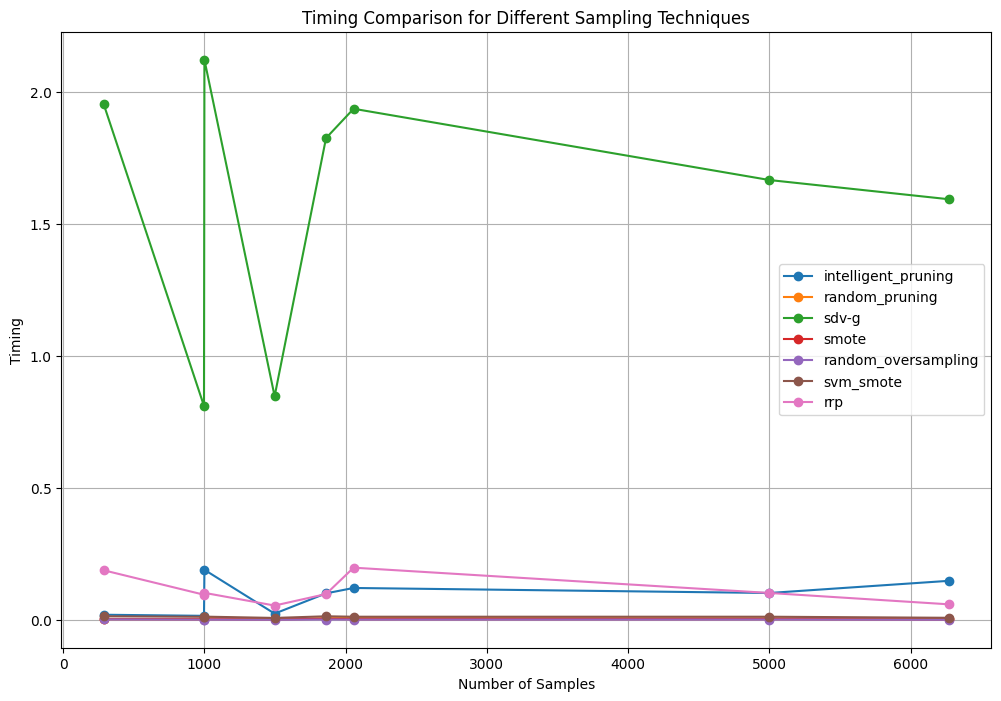

In [34]:
# Sort the dictionary based on keys
sorted_timing_graph_dict = dict(sorted(timing_graph_dict.items(), key=lambda x: x[0], reverse=True))

# Plotting
plt.figure(figsize=(12, 8))
# Convert dict_keys to list for subscripting
for technique in list(sorted_timing_graph_dict[list(sorted_timing_graph_dict.keys())[0]].keys()):
    plt.plot(list(sorted_timing_graph_dict.keys()), [sorted_timing_graph_dict[key][technique] for key in list(sorted_timing_graph_dict.keys())], label=technique, marker='o')


plt.xlabel('Number of Samples')
plt.ylabel('Timing')
plt.title('Timing Comparison for Different Sampling Techniques')
plt.legend()
plt.grid(True)
plt.show()